### Text recognition on image

In [ ]:
# import all the modules
import tensorflow as tf
import numpy as np
import cv2
from imutils.object_detection import non_max_suppression
import pytesseract
from matplotlib import pyplot as plt
from scipy import ndimage
from scipy import misc
from random import randint
import random
import os
from sklearn.model_selection import train_test_split
from tensorflow.contrib.layers import flatten

We supposed that we have load the image so X for the image and y for the target

In [ ]:
# Placeholder
x = tf.placeholder(tf.float32, (None, None, None, 3), name="x") # input for the image
y = tf.placeholder(tf.float32, (None, 2), name="y") # The target of the image
dropout = tf.placeholder(tf.float32, (None), name="dropout")

def create_conv(prev, filter_size, nb):
    # For any convolution
    conv_W = tf.Variable(tf.truncated_normal(shape=(filter_size, filter_size, int(prev.get_shape()[-1]), nb))) # Filter for the 1st layer of the taken image
    conv_b = tf.Variable(tf.zeros(nb)) # seconde filter
    conv   = tf.nn.conv2d(prev, conv_W, strides=[1, 1, 1, 1], padding='SAME') + conv_b
    conv = tf.nn.relu(conv)
    conv   = tf.nn.conv2d(conv, conv_W, strides=[1, 1, 1, 1], padding='SAME') + conv_b
    # Activation: relu
    conv = tf.nn.relu(conv)
    # Pooling
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return conv

conv = create_conv(x, 8, 32)
conv = create_conv(conv, 5, 64)
conv = create_conv(conv, 5, 128)
conv = create_conv(conv, 5, 256)
conv = create_conv(conv, 5, 512)

flat = flatten(conv)

# First fully connected layer
fc1_W = tf.Variable(tf.truncated_normal(shape=(int(flat.get_shape()[1]), 512)))
fc1_b = tf.Variable(tf.zeros(512))
fc1   = tf.matmul(flat, fc1_W) + fc1_b

# Activation.
fc1    = tf.nn.relu(fc1)

#fc1 = tf.nn.dropout(fc1, keep_prob=dropout)

# Last layer: Prediction
fc3_W  = tf.Variable(tf.truncated_normal(shape=(512, 2)))
fc3_b  = tf.Variable(tf.zeros(2))
logits = tf.matmul(fc1, fc3_W) + fc3_b

softmax = tf.nn.softmax(logits)



In [ ]:
# Loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

# Accuracy
predicted_cls = tf.argmax(softmax, axis=1)
correct_prediction = tf.equal(predicted_cls, tf.argmax(y, axis=1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001)
training_operation = optimizer.minimize(loss_operation)

### Train Model 

In [ ]:
# Train Model
batch_size = 255
sess =  tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
def augmented_batch(batch):
    n_batch = []
    
    for img in batch:
        if random.uniform(0, 1) > 0.75:
            process_img = Image.fromarray(np.uint8(img.reshape(75, 75, 3))).rotate(randint(-45, 45))
            n_img = np.array(process_img)
            n_batch.append(n_img.reshape(75, 75, 3))
        else:
            n_batch.append(img)
        
    return n_batch

In [ ]:
i = 0
for epoch in range(0, 10000):
    print(">> Epoch: %s" % epoch)
    # Shuffle
    indexs = np.arange(len(X_train))
    np.random.shuffle(indexs)
    X_train = X_train[indexs]
    y_train = y_train[indexs]
    
    for b in range(0, len(X_train), batch_size):
        batch = augmented_batch(X_train[b:b+batch_size])
        #batch = X_train[b:b+batch_size]

        if i % 20 == 0:
            #print(sess.run(predicted_cls, feed_dict={dropout: 1.0, x: batch, y: y_train[b:b+batch_size]}))
            print("Accuracy [Train]:", sess.run(accuracy_operation, feed_dict={dropout: 1.0, x: batch, y: y_train[b:b+batch_size]}))            
        sess.run(training_operation, feed_dict={dropout: 0.8, x: batch, y: y_train[b:b+batch_size]})
        i += 1

    if epoch % 2 == 0:
        accs = []
        for b in range(0, len(X_valid), batch_size):
            accs.append(sess.run(accuracy_operation, feed_dict={dropout: 1., x: X_valid[b:b+batch_size], y: y_valid[b:b+batch_size]}))
        print("Accuracy [Validation]", np.mean(accs))

In [ ]:
# Save the train model on a file 
model.save('model_detector') 

## Utilisation du modèle 

In [112]:
# emplacement de l'image
img ="data/1190-receipt.jpg"

In [113]:
image = cv2.imread(img)
# Keep a copy of the original image and modify the image shape
orig = image.copy()
(origH, origW) = image.shape[:2]

# set the new height and width to default 320 by using args #dictionary.  
(newW, newH) = (320, 320)

# Keep the translation ration between the original image and the final image, this allows you to synchronize the positions later
rW = origW / float(newW)
rH = origH / float(newH)

# Set new dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# Set the Blob for the model
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)

In [114]:
# Load the train model
net = cv2.dnn.readNet('model_detector.pb')

In [116]:
# forward on the network and select the specify layers names
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

In [117]:
## return the box if the probbility score reach the prob_score
def predictions(prob_score, geo):
	(numR, numC) = prob_score.shape[2:4]
	boxes = []
	confidence_val = []
	for y in range(0, numR):
		scoresData = prob_score[0, 0, y]
		x0 = geo[0, 0, y]
		x1 = geo[0, 1, y]
		x2 = geo[0, 2, y]
		x3 = geo[0, 3, y]
		anglesData = geo[0, 4, y]
		for i in range(0, numC):
			if scoresData[i] < 0.1 : # min_probability
				continue

			(offX, offY) = (i * 4.0, y * 4.0)

			# we recover the angle of inclination of the text
			angle = anglesData[i]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# set the new dimensions
			h = x0[i] + x2[i]
			w = x1[i] + x3[i]

			# set the text emplacement
			endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
			endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
			startX = int(endX - w)
			startY = int(endY - h)

			boxes.append((startX, startY, endX, endY))
			confidence_val.append(scoresData[i])

	# return the box with the highest probability text
	return (boxes, confidence_val)

In [118]:
# turn the prediction 
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs=confidence_val)

In [119]:
# for the pytesserac module add this to run on local 
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

In [120]:
## the list of the extracted text
results = []

# get the coord of the box
for (startX, startY, endX, endY) in boxes:
	# With the rate get the new position on the original image 
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	# extract the region where are text
	r = orig[startY:endY, startX:endX]

	# configure the transformation -eng for english language -oem for the model and 8 the the type of the return
	configuration = ("-l eng --oem 1 --psm 8")
    ## turn the transformation with the config
	text = pytesseract.image_to_string(r, config=configuration)

	# get the text with position 
	results.append(((startX, startY, endX, endY), text))

In [121]:
# load the save image
orig_image = orig.copy()

# for each text pout it on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
	print("{}\n".format(text))
	text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
	cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
		(0, 0, 255), 2)
	cv2.putText(orig_image, text, (start_X, start_Y - 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0, 255), 2)


able

cREDI

ates

Total

subtotal

‘Dini

CARD.

ORDER

g1495,

Bryant

Garli

‘Sharpe

“onion 8

$16.95

House

Naan

sh Curry

$118

Bomba

1S

2018 1

Grill H

$16.95

ieee



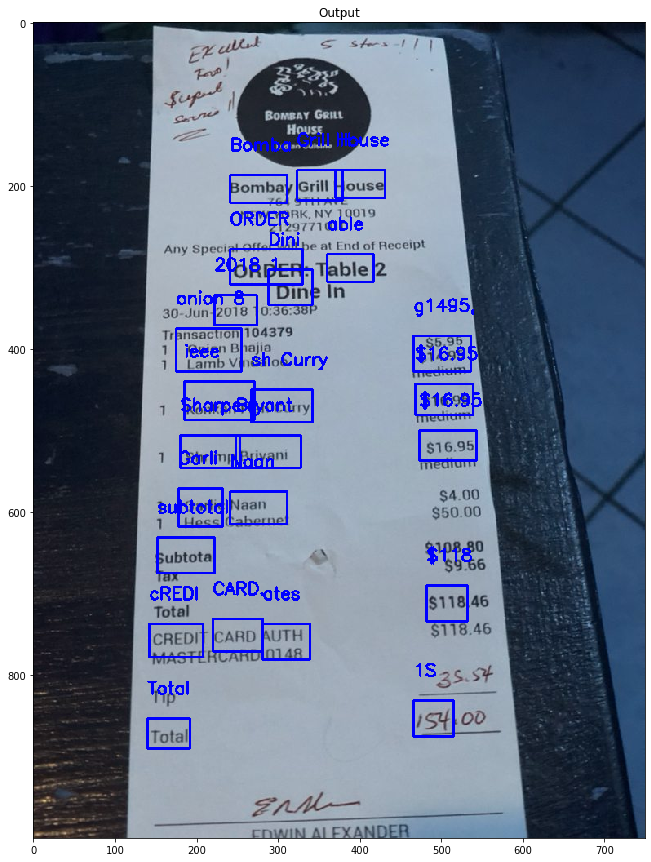

In [122]:
# Visualze the result on an example
plt.figure(figsize=(15,15))
plt.imshow(orig_image)
plt.title('Output')
plt.show()

In [124]:
# Save the result
cv2.imwrite('result.jpg', orig_image) 

True